In [76]:
# all imports

import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
#init_printing(use_unicode=True)
warnings.simplefilter('ignore')
import re
from sympy import *
import sympy
init_printing()

class ModuleProperties:

    def __init__(self, stoich_matrix, num_internal_species, species_names):
        self.stoich_matrix = sympy.Matrix(stoich_matrix)
        self.num_internal_species = num_internal_species
        self.num_external_species = self.stoich_matrix.shape[0] - num_internal_species
        self.num_species = self.stoich_matrix.shape[0]
        self.num_reactions = self.stoich_matrix.shape[1]
        self.species_labels = {i: item for i, item in enumerate(species_names)}
        self.species_names = species_names
        self.internal_stoich_matrix = self.stoich_matrix[0:self.num_internal_species, :]
        self.external_stoich_matrix = self.stoich_matrix[self.num_internal_species: len(self.stoich_matrix), :]


        # LABELLING FOR SPECIES, FORCES, EDGE CURRENTS, CHEMICAL POTENTIALS

        #self.species_labels = []

        self.chemical_potentials = []
     

        for n in range(self.num_species):
            
            #species_symbol = species_names[n]
            species_symbol = symbols(species_names[n])
            #self.species_labels.append(species_symbol)

            chem_pot = symbols(f"\mu_{species_symbol}")
            self.chemical_potentials.append(chem_pot)
            

        self.chemical_potentials_vector = Matrix(self.chemical_potentials).T  # make a vector out of the labelled chemical potentials
        
        # LABELS FOR ALL RESISTANCES AND REACTIONS

        
        resistances = [] # define list to hold reaction labels
        edge_currents_j = [] # to hold the js
        forces = [] # to hold reaction level forces

        for n in range(self.num_reactions): # loop over each reaction
            nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
            resistances.append(nth_resistance) # add to list of resistance

            nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth edge current
            edge_currents_j.append(nth_edge_currents_j) # add to list of currents

            reaction_vector = -1* self.stoich_matrix[:,n] # take the column of SM that corresponds to nth reaction
            
            forces.append(self.chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
        
        
        self.force_vector = Matrix(forces) # create a vector of reaction level forces
        self.edge_currents_vector = Matrix(edge_currents_j) # make a vector out of the js


        # reaction resistance in terms of r = f/j

        reaction_level_res = [] # to hold reaction level resistances

        for n in range(self.num_reactions): # loop over each reaction
            symbolic_resistance = self.force_vector[n] / self.edge_currents_vector[n]

            reaction_level_res.append(symbolic_resistance)

        self.reaction_level_resistances = reaction_level_res # output reaction level resistances in terms of r = f/j

        self.kinetic_form_resistance_matrix = Matrix.diag(reaction_level_res) # output reaction level res. matrix in terms of r = f/j

    #==========================================================================================================================================
    # REACTION LEVEL CYCLES

    def calculate_reaction_cycle_matrix(self):

        """ This method calculates the reaction level cycles matrix for the internal species of the module using the 
        kernel of the internal stoichiometric matrix.
        
        Returns:
            cycle_matrix (Sympy Matrix): Reaction level cycles matrix for internal species
        """
        
        reaction_cycles = (self.internal_stoich_matrix).nullspace() # finds the kernel for the SM internal

        # Check if there are any cycles:

        if not reaction_cycles:

            print("No internal cycles. Kernel is empty.")

        # build cycle matrix from kernel vectors if kernel is NOT empty

        else:

            cycle_matrix = reaction_cycles[0] # add first vector to cycle matrix so we can add rest later

            for cycle in reaction_cycles[1:]: # starting at second vector in kernel

                cycle_matrix = cycle_matrix.row_join(cycle) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together


            self.cycle_matrix = cycle_matrix # assign cycle matrix to self for use in other methods
            
            return cycle_matrix # return the cycle matrix
        
    #==========================================================================================================================================
    # COUPLING MATRICES 
 
    def calculate_coupling_matrix(self):

        """ This method calculates the coupling matrix between internal and external species using reaction cycle matrix 
        and SM of external species.

        Returns:
            phi (Sympy Matrix): Coupling matrix between internal and external species
        """

        phi = self.external_stoich_matrix * self.calculate_reaction_cycle_matrix()

        self.phi = phi
        return phi
    
    #==========================================================================================================================================
    # CONSERVATION LAW MATRICES

    def calculate_conservation_laws(self):

        """ This method calculates the conservation law matrices for the full stoichiometric matrix and the chemostat species only.
        
        Returns:
            cons_laws.T (Sympy Matrix): Conservation law matrix for the full stoichiometric matrix  
            chemostat_laws.T (Sympy Matrix): Conservation law matrix for the chemostat species only
        """

        cokernel_SM = (self.stoich_matrix.T).nullspace() # finds the cokernel of the full SM

        if not cokernel_SM:

            print("No conservation laws. Cokernel of Stoichiometric Matrix empty.")

        else:

            cons_laws = cokernel_SM[0] # adds first element of cokernel

            for vec in cokernel_SM[1:]: # add vectors from next row onwards

                cons_laws = cons_laws.row_join(vec)


        #
        # Broken external laws for chemostat , deriving from the coupling matrix
        #

        coupling_matrix = self.calculate_coupling_matrix() # define the coupling matrix using the function defined previously

        cokernel_coupling_matrix = coupling_matrix.T.nullspace() # find the cokernel of the coupling matrix

        if not cokernel_coupling_matrix:

            print("No chemostat conservation laws. Cokernel of Coupling Matrix is empty.")

        # if cokernel is NOT empty

        else:

            chemostat_laws = cokernel_coupling_matrix[0] # add first vector to chemostat conservation law matrix so we can add rest later

            for law in cokernel_coupling_matrix[1:]: # starting at second vector in kernel

                chemostat_laws = chemostat_laws.row_join(law) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together



        self.cons_laws = cons_laws.T # assign to self for use in other methods
        self.chemostat_cons_laws = chemostat_laws.T # assign to self for use in other methods

        return cons_laws.T, chemostat_laws.T # return transpose to match equations in paper { L^(1) and l^(1) respectively}
    
    #==========================================================================================================================================
    # SELECTION MATRIX

    def calculate_selection_matrix(self):

        """ This method calculates the selection matrix for the chemostat conservation laws.
        
        Returns:
            selection_matrix (Sympy Matrix): Selection matrix for the chemostat conservation laws
        """

        chemostat_laws = self.calculate_conservation_laws()[1] # get chemostat conservation laws from previous method

        null_basis_chemostat_laws = (chemostat_laws).nullspace() # find nullspace of chemostat conservation laws

        if null_basis_chemostat_laws:

            selection_matrix = sympy.Matrix.hstack(*null_basis_chemostat_laws) # build selection matrix from nullspace vectors

        else:

            selection_matrix = sympy.Matrix([]) # empty matrix if no nullspace

        self.selection_matrix = selection_matrix # assign to self for use in other methods

        return selection_matrix

    #==========================================================================================================================================
    # PHYSICAL CURRENTS

    def calculate_physical_currents(self):

        currents_constraints = sympy.solve (self.internal_stoich_matrix * self.edge_currents_vector, self.edge_currents_vector)

        physical_currents = (-1* self.external_stoich_matrix * self.edge_currents_vector).subs(currents_constraints)

        self.physical_currents = physical_currents # assign to self for use in other methods

        return physical_currents

    #==========================================================================================================================================
    # REACTION LEVEL RESISTANCE MATRIX
    
    def calculate_reaction_resistance_matrix(self):

        """ Calculates the reaction level resistance matrix for the module, including an auto-labelling of reactions in the SM 
        according to the number of columns in the SM for use in Sympy operations.

        Returns:
            reaction_resistance_matrix (Sympy Matrix): Reaction level resistance matrix for the module"""
                    
        resistances = [] # define list to hold reaction labels
    
        for n in range(self.num_reactions): # loop over each reaction

            nth_reaction = symbols(f"r{n+1}") # assign name of nth reaction

            resistances.append(nth_reaction) # add to list of reactions


    
        reaction_resistance_matrix = Matrix.diag(resistances) # create diagonal reaction level resistance matrix from list of reactions

        self.reaction_resistance_matrix = reaction_resistance_matrix # assign to self for use in other methods

        return reaction_resistance_matrix

    #==========================================================================================================================================
    # CYCLE RESISTANCE MATRIX

    def calculate_cycle_resistance_matrix(self):

        """ Uses the reaction level resistance matrix and reaction cycles matrix to calculate the cycle resistance matrix for the module.
        
        Returns:
            cycle_resistance_matrix (Sympy Matrix): Cycle resistance matrix for the module"""

        cycle_resistance_matrix = self.calculate_reaction_cycle_matrix().T * self.calculate_reaction_resistance_matrix() \
        * self.calculate_reaction_cycle_matrix()

        self.cycle_resistance_matrix = cycle_resistance_matrix # assign to self for use in other methods

        return cycle_resistance_matrix    
    
    #==========================================================================================================================================
    # PHYSICAL CONDUCATANCE MATRICES

    def calculate_physical_conductance_matrix(self):
        """ This method calculates the physical conductance matrix for the module using the coupling matrix and cycle resistance matrix.

        Returns:
            physical_conductance_matrix (Sympy Matrix): Physical conductance matrix for the module
        """

        physical_conductance_matrix = self.calculate_coupling_matrix() * self.calculate_cycle_resistance_matrix().inv() \
              * self.calculate_coupling_matrix().T        

        self.physical_conductance_matrix = physical_conductance_matrix # assign to self for use in other methods

        return physical_conductance_matrix
    
    #==========================================================================================================================================
    # FUNDAMENTAL CONDUCTANCE MATRIX

    def calculate_fundamental_conductance_matrix(self):
        """ This method calculates the fundamental conductance matrix for the module using the selection matrix and physical conductance matrix.

        Returns:
            fundamental_conductance_matrix (Sympy Matrix): Fundamental conductance matrix for the module
        """

        fundamental_conductance_matrix = self.calculate_selection_matrix().pinv() * self.calculate_physical_conductance_matrix() * self.calculate_selection_matrix().T.pinv()

        self.fundamental_conductance_matrix = fundamental_conductance_matrix # assign to self for use in other methods

        return fundamental_conductance_matrix
    
    #==========================================================================================================================================
    # FUNDAMENTAL RESISTANCE MATRIX

    def calculate_fundamental_resistance_matrix(self):
        """ This method calculates the fundamental resistance matrix for the module using the selection matrix and physical conductance matrix.

        Returns:
            fundamental_resistance_matrix (Sympy Matrix): Fundamental resistance matrix for the module
        """

        fundamental_resistance_matrix = self.calculate_fundamental_conductance_matrix().inv()

        self.fundamental_resistance_matrix = fundamental_resistance_matrix # assign to self for use in other methods

        return fundamental_resistance_matrix

    
class CombiningModules:

    def __init__(self, left_mod, right_mod):
                
        #=====================================================================================================================================
        # IDENTIFY MATCHING EXTERNAL SPECIES

        left_ext_indices  = list(range(left_mod.num_internal_species, left_mod.num_species)) # external species indices for left module
        right_ext_indices = list(range(right_mod.num_internal_species, right_mod.num_species)) # external species indices for right module

        left_ext_names  = {i: left_mod.species_labels[i] for i in left_ext_indices} # external species names for left module
        right_ext_names = {j: right_mod.species_labels[j] for j in right_ext_indices} # external species names for right module

        matching_pairs = []
        for i_ext, name_i in left_ext_names.items(): # loop over left external species
            for j_ext, name_j in right_ext_names.items(): # loop over right external species
                if name_i == name_j: # check for matching names
                    matching_pairs.append((i_ext, j_ext)) # store matching index pairs

        if matching_pairs: # if there are matching pairs
            keys_1, keys_2 = zip(*matching_pairs) # unzip into separate lists
            keys_1, keys_2 = list(keys_1), list(keys_2) # convert to lists
        else:
            keys_1, keys_2 = [], [] # no matches found

        # Convert global species indices → external row indices
        left_match_rows  = [i - left_mod.num_internal_species  for i in keys_1] # left module matching external row indices
        right_match_rows = [j - right_mod.num_internal_species for j in keys_2] # right module matching external row indices

        #===================================================================================================================================
        # COMPUTE LEFT AND RIGHT PHYSICAL CURRENTS AND SOLVE MATCHING CONSTRAINTS

        left_curr  = left_mod.calculate_physical_currents() # physical currents for left module
        right_curr = right_mod.calculate_physical_currents() # physical currents for right module

        left_right_current  = sympy.Matrix([left_curr[r]  for r in left_match_rows]) # left module matching external currents
        right_left_current  = sympy.Matrix([right_curr[r] for r in right_match_rows]) # right module matching external currents

        left_left_current = sympy.Matrix([left_curr[r] for r in range(left_mod.num_external_species)
            if r not in left_match_rows]) # creates a matrix of left unmatched external currents

        right_right_current = sympy.Matrix([right_curr[r] for r in range(right_mod.num_external_species)
            if r not in right_match_rows]) # creates a matrix of right unmatched external currents

        constraint_eqs = [left_right_current[k] + right_left_current[k]
            for k in range(len(left_right_current)) ] # build list of constraint equations for matching currents

        symbols_to_solve = left_right_current.free_symbols # get symbols to solve for from left matching currents
        solutions = sympy.solve(constraint_eqs, symbols_to_solve) # solve constraints for matching currents

        left_curr  = left_curr.subs(solutions) # substitute solutions into left physical currents
        right_curr = right_curr.subs(solutions) # substitute solutions into right physical currents

        left_left_current = sympy.Matrix([left_curr[r] for r in range(left_mod.num_external_species)
            if r not in left_match_rows]) # creates a matrix of left unmatched external currents after substitution

        right_right_current = sympy.Matrix([right_curr[r] for r in range(right_mod.num_external_species)
            if r not in right_match_rows]) # creates a matrix of right unmatched external currents after substitution

        combined_currents = sympy.Matrix.vstack(left_left_current, right_right_current) # creates a vector of physical currents for combined module
        self.physical_currents = combined_currents # assign to self for use in other methods

        #======================================================================================================================================
        # BUILDING THE COMBINED STOICHIOMETRIC MATRIX

        matching_stoich_left = sympy.Matrix([left_mod.external_stoich_matrix.row(r) for r in left_match_rows]) # matching external stoich rows from left module

        matching_stoich_right = sympy.Matrix([right_mod.external_stoich_matrix.row(r) for r in right_match_rows]) # matching external stoich rows from right module

        external_left_unmatched = sympy.Matrix([left_mod.external_stoich_matrix.row(r)
            for r in range(left_mod.external_stoich_matrix.rows)
            if r not in left_match_rows]) # unmatched external stoich rows from left module

        external_right_unmatched = sympy.Matrix([right_mod.external_stoich_matrix.row(r)
            for r in range(right_mod.external_stoich_matrix.rows)
            if r not in right_match_rows]) # unmatched external stoich rows from right module

        stoich_matrix = BlockMatrix([
            [left_mod.internal_stoich_matrix,
            zeros(left_mod.internal_stoich_matrix.rows, right_mod.internal_stoich_matrix.cols)],

            [matching_stoich_left,
            matching_stoich_right],

            [zeros(right_mod.internal_stoich_matrix.rows, left_mod.internal_stoich_matrix.cols),
            right_mod.internal_stoich_matrix],

            [external_left_unmatched,
            zeros(external_left_unmatched.rows, right_mod.internal_stoich_matrix.cols)],

            [zeros(external_right_unmatched.rows, left_mod.internal_stoich_matrix.cols),
            external_right_unmatched]]) # build combined stoichiometric matrix using sympy BlockMatrix

        self.stoich_matrix = sympy.Matrix(stoich_matrix) # convert BlockMatrix to regular Matrix and assign to self

        # ===================================================================================================================================
        # UPDATING ATTRIBUTES OF THE COMBINED MODULE TO WORK WITH OTHER METHODS

        self.num_internal_species = (left_mod.num_internal_species + right_mod.num_internal_species + len(keys_1)) # total internal species count for combined module

        self.num_external_species = self.stoich_matrix.rows - self.num_internal_species # total external species count for combined module
        self.num_species = self.stoich_matrix.rows # total species count for combined module
        self.num_reactions = left_mod.num_reactions + right_mod.num_reactions # total reactions count for combined module

        self.internal_stoich_matrix = self.stoich_matrix[:self.num_internal_species, :]
        self.external_stoich_matrix = self.stoich_matrix[self.num_internal_species:, :]

        # ===================================================================================================================================
        # CREATING A COMBINED DICTIONARY OF SPECIES LABELS

        left_internal_idx  = list(range(left_mod.num_internal_species)) # internal species indices for left module
        right_internal_idx = list(range(right_mod.num_internal_species)) # internal species indices for right module

        left_external_idx  = left_ext_indices # external species indices for left module
        right_external_idx = right_ext_indices # external species indices for right module

        left_ext_name_to_idx  = {left_mod.species_labels[i]: i for i in left_external_idx} # mapping of left external species names to indices
        right_ext_name_to_idx = {right_mod.species_labels[i]: i for i in right_external_idx} # mapping of right external species names to indices

        matching_names = set(left_ext_name_to_idx) & set(right_ext_name_to_idx) # find matching external species names

        left_matching_idx  = [left_ext_name_to_idx[name]  for name in matching_names] # indices of matching external species in left module
        right_matching_idx = [right_ext_name_to_idx[name] for name in matching_names] # indices of matching external species in right module

        left_unmatched_idx  = [i for i in left_external_idx  if i not in left_matching_idx] # indices of unmatched external species in left module
        right_unmatched_idx = [i for i in right_external_idx if i not in right_matching_idx] # indices of unmatched external species in right module

        combined_labels = {} # initialize empty dictionary for combined species labels
        counter = 0 # counter for combined species indices

        for i in left_internal_idx: # add left internal species labels
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in left_matching_idx: # add matching species labels from left module
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in right_internal_idx: # add right internal species labels
            combined_labels[counter] = right_mod.species_labels[i]
            counter += 1

        for i in left_unmatched_idx: # add unmatched species labels from left module
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in right_unmatched_idx: # add unmatched species labels from right module
            combined_labels[counter] = right_mod.species_labels[i]
            counter += 1

        self.species_labels = combined_labels # assign to self for use in other methods
        self.species_names = list(combined_labels.values()) # list of combined species names

        #=========================================================================================================================================
        # Left right splitting the conservation law matrices

        left_mod_chemostat_cons_laws = left_mod.calculate_conservation_laws()[1]
        right_mod_chemostat_cons_laws = right_mod.calculate_conservation_laws()[1]

        left_mod_left_cons_laws = left_mod_chemostat_cons_laws[:, :len(left_left_current)]
        left_mod_right_cons_laws = left_mod_chemostat_cons_laws[:, len(left_left_current):]
        right_mod_left_cons_laws = right_mod_chemostat_cons_laws[:, :len(right_left_current)]
        right_mod_right_cons_laws = right_mod_chemostat_cons_laws[:, len(right_left_current):]

        #=========================================================================================================================================
        # Constructing matrices L_i, L_e and v using these to determine the chemostat conservation laws of the combined module and the selection matrix

        L_i = sympy.Matrix.vstack(-left_mod_right_cons_laws, right_mod_left_cons_laws)

        L_e = sympy.BlockMatrix([
        [left_mod_left_cons_laws, sympy.ZeroMatrix(left_mod_left_cons_laws.shape[0], right_mod_right_cons_laws.shape[1])],
        [sympy.ZeroMatrix(right_mod_right_cons_laws.shape[0], left_mod_left_cons_laws.shape[1]), right_mod_right_cons_laws]])
        
        L_e = sympy.Matrix(L_e)  

        null_basis_L_i = (L_i.T).nullspace()
        if null_basis_L_i:
            v = sympy.Matrix.hstack(*null_basis_L_i).T
        else:
            v = sympy.Matrix([])

        combined_conservation_laws_chemostat = v * L_e
        self.conservation_laws_chemostat = combined_conservation_laws_chemostat

        null_basis_cons_laws = (combined_conservation_laws_chemostat).nullspace()
        if null_basis_cons_laws:
            combined_selection_matrix = sympy.Matrix.hstack(*null_basis_cons_laws)
        else:
            combined_selection_matrix = sympy.Matrix([])

        self.selection_matrix = combined_selection_matrix

        #=========================================================================================================================================
        # Calculating pi and PI matricies 

        pi = sympy.Matrix(L_i.pinv() * L_e)
        pi_rows, pi_cols = pi.shape

        identity_part_1 = sympy.eye(len(left_left_current), pi_cols)
        pi_1_3 = identity_part_1.col_join(pi)

        identity_part_2 = sympy.eye(len(right_right_current), pi_cols-pi_rows)
        zeros_part_2 = sympy.zeros(len(right_right_current), pi_rows)
        bottom_part_2 = zeros_part_2.row_join(identity_part_2)
        pi_2_3 = (-pi).col_join(bottom_part_2)

        PI_1_3 = sympy.Matrix(left_mod.selection_matrix.pinv() * pi_1_3 * combined_selection_matrix)
        PI_2_3 = sympy.Matrix(right_mod.selection_matrix.pinv() * pi_2_3 * combined_selection_matrix)

        #=========================================================================================================================================
        # Relabelling conductance matrix of right module so that the indicies do not overlap with those of the left module

        SUB_TO_DIGIT = {'₀':'0','₁':'1','₂':'2','₃':'3','₄':'4','₅':'5','₆':'6','₇':'7','₈':'8','₉':'9'}
        DIGIT_TO_SUB = {v:k for k,v in SUB_TO_DIGIT.items()}

        def parse_symbol_name(name):
            if '_' in name:
                prefix, idx = name.split('_', 1)
                if idx.isdigit():
                    return prefix, idx, 'underscore'
            i = len(name)-1
            while i >= 0 and name[i].isdigit():
                i -= 1
            if i < len(name)-1:
                return name[:i+1], name[i+1:], 'ascii'
            i = len(name)-1
            while i >= 0 and name[i] in SUB_TO_DIGIT:
                i -= 1
            if i < len(name)-1:
                prefix = name[:i+1]
                idx = ''.join(SUB_TO_DIGIT[ch] for ch in name[i+1:])
                return prefix, idx, 'unicode'
            return None, None, None

        def build_name(prefix, new_index, style):
            if style == 'underscore':
                return f"{prefix}_{new_index}"
            if style == 'unicode':
                return f"{prefix}{''.join(DIGIT_TO_SUB[d] for d in str(new_index))}"
            return f"{prefix}{new_index}"

        def shift_expr_variables(expr, shift):
            symbols = expr.atoms(sympy.Symbol)
            if not symbols:
                return expr
            subs = {}
            for s in symbols:
                prefix, idx_str, style = parse_symbol_name(s.name)
                if prefix is None:
                    continue
                new_idx = int(idx_str) + int(shift)
                new_name = build_name(prefix, new_idx, style)
                subs[s] = sympy.Symbol(new_name, **s.assumptions0)
            return expr.xreplace(subs)

        def shift_matrix_variables(matrix, shift):
            return matrix.applyfunc(lambda e: shift_expr_variables(e, shift))
        
        left_mod_fundamental_resistance_matrix = left_mod.fundamental_resistance_matrix
        right_mod_fundamental_resistance_matrix = shift_matrix_variables(right_mod.fundamental_resistance_matrix, left_mod.num_reactions)

        #=========================================================================================================================================
        # Calculating the conductance matrix of the combined module

        combined_fundamental_resistance_matrix = PI_1_3.T * left_mod_fundamental_resistance_matrix * PI_1_3 + PI_2_3.T * right_mod_fundamental_resistance_matrix * PI_2_3

        #=========================================================================================================================================
        # Storing attributes to self that are need for an iterative process of combining modules

        self.fundamental_resistance_matrix = combined_fundamental_resistance_matrix
        self.fundamental_conductance_matrix = combined_fundamental_resistance_matrix.inv()
        self.selection_matrix = combined_selection_matrix
        self.conservation_laws_chemostat = combined_conservation_laws_chemostat

    def calculate_physical_currents(self):
        
        return self.physical_currents
    
    def calculate_conservation_laws(self):
        
        return 0, self.conservation_laws_chemostat


        
        

In [468]:
from numba import jit
import time
import math
from random import random

In [565]:
class RunSSA:

    def __init__(self, module_for_simulating, initial_counts, rates, simulation_length):

        self.stoich_matrix = module_for_simulating.stoich_matrix
        self.species_names = module_for_simulating.species_names
        self.current_pops = initial_counts
        self.rates_list = rates
        self.final_time = simulation_length
        self.num_internal_species = module_for_simulating.num_internal_species

        init_functions_start = time.time()
        self.SM_with_reverse_stoichiometry = self.create_SM_with_reverse_stoichiometry()
        self.current_pops_index = self.determine_consumed_species_in_each_reaction()
        init_functions_end = time.time()

        print(r"Init functions time taken: {}".format(-(init_functions_start - init_functions_end)))

    
    def create_SM_with_reverse_stoichiometry(self):

        """ This method creates a new stoichiometric matrix that concatenates a backwards reaction for each reaction
        present in the origional stoichiometric matrix, in the order: [forwards1 backwards1 ... ] """

        SM = []

        for p in range(self.stoich_matrix.cols):
            SM.append(self.stoich_matrix[:, p])
            SM.append(-self.stoich_matrix[:, p])

        self.SM_with_reverse_stoichiometry = Matrix.hstack(*SM)

        return self.SM_with_reverse_stoichiometry


    def determine_consumed_species_in_each_reaction(self):

        """ This is used later to calculate the propensity vector. This method finds which species are consumed in each reaction vector,
        then stores the index corresponding to that species' position in the reaction vector in a new list. This creates a list of lists
        of form: [[0,2],[3,1]] is telling us reaction 1 consumes the species in position 0 and 2 in the reaction vector.
        
        Ultimately, this list tells us which population counts we need to include in the combination for the propensity,
        e.g. for reaction 1 above, propensity is: p1 = species[0]*species[2]*rate, for a list of species.
        
        this requires the order of species in species_names, current_pops, SM, to be the same.  """

        #start1 = time.time()

        self.current_pops_index = []

        for l in range(self.SM_with_reverse_stoichiometry.cols): # repeat for all reactions

            reaction = self.SM_with_reverse_stoichiometry[:,l] # extract each reaction one by one

            current_reaction_indexes = []

            for p in range(len(reaction)): # go through each element in the reaction

                if reaction[p] < 0: # if an element is negative, that species is consumed in the reaction

                    current_reaction_indexes.append(p) # store the index of the reaction (is the same as in the current_pops list)
            
            self.current_pops_index.append(current_reaction_indexes)

        #end1 = time.time()
        #print(f"Time taken to determine consumed species in each reaction: {end1 - start1:.6f}")

        return self.current_pops_index


    
    
    def calculate_propensity_function(self):
        
        """ This method calculates the propensity vector for the current time interval of the SSA. It does this by using the indexes of
        consumed species calculated in determine_consumed_species_in_each_reaction() and the inputted rates to calculated the propensity
        vector as a list of form: [propensity_r1+, propensity_r1-, ...]
         """
        
        #tart = time.time()

        propensity_vector = [0] * (self.SM_with_reverse_stoichiometry.cols)

        for a in range(self.SM_with_reverse_stoichiometry.cols): # repeat for all reactions

            #used_counts = []
            product_of_counts = 1.0

            for index in self.current_pops_index[a]: # loop over each species used in this reaction
                
                #used_counts.append(self.current_pops[index]) # create a list containing the actual current count values 
                product_of_counts *= self.current_pops[index]

            #propensity = np.prod(used_counts) * self.rates_list[a] # calculate the propensity for this reaction
            propensity = product_of_counts * self.rates_list[a]

            propensity_vector[a] = propensity # add to the propensity vector

        self.propensity_vector = propensity_vector
        
        #end = time.time()
        #print(f"Time taken to calculate propensity vector: {end - start:.6f}")

        return self.propensity_vector


    def run_SSA_and_plot_counts(self):

        """ This method runs the SSA in a generalised method that depends on the consistent ordering of used lists."""
        
        # ----------------------------------------------------------------
        # Initial conditions
        # ----------------------------------------------------------------

        t, T = 0.0, self.final_time # initial and final time

        times = [t]

        # set initial pops, in order: same as SM, e.g. for mod 1 from 2025 [Ea, Eas, Eas2, S, Na] 
        counts_list = [[x] for x in self.current_pops] # in order: same as rows of SM

        #rates_list = [0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01] # in order: kf_1, kb_1, kf_2, ... , kf_n, kb_n

        # to start tracking quantities needed for current calcs:
        reaction_chosen_tracker = [0] * (self.SM_with_reverse_stoichiometry.cols)

        # to start tracking quantities needed for thermodynamic force calcs:
        propensity_ratios = [[] for _ in range(self.stoich_matrix.cols)] # need a list of length the number of reactions (incl forwards + back)
        
        # ----------------------------------------------------------------


        # ----------------------------------------------------------------
        # algorithm:
        # ----------------------------------------------------------------

        loop_time_start = time.time()

        iterations = 0

        total_prop_time = 0
        updates_time = 0
        r_selection_time = 0
        sampling_time = 0
        summing_prop_time = 0
        tau_time = 0

        while t < T:

            prop_t_start = time.time()
            propensity_vector = self.calculate_propensity_function()
            prop_t_end = time.time()
            total_prop_time += (prop_t_start - prop_t_end)

            summing_prop_time_start = time.time()
            a0 = sum(propensity_vector)
            summing_prop_time_end = time.time()
            summing_prop_time += summing_prop_time_end - summing_prop_time_start

            # if a0 == 0:
            #     break
            
            r1, r2 = np.random.rand(2) # draw two random numbers - how random are they, use qiskit for quanutm randomness?

            tau_time_start = time.time()

            tau = -math.log(r1) / a0

            tau_time_end = time.time()
            tau_time += tau_time_end - tau_time_start

            # Now need to select which reaction will occur using r2, prob is weighted by which is most likely to occur at the current state of the system:

            target_value = r2*a0

            cumulative = 0

            

            r_selection_start = time.time()
            for n in range(len(propensity_vector)): # selects which reaction to fire, probab. is proportional to the weighting of propensity

                cumulative += propensity_vector[n]

                if target_value <= cumulative:

                    reaction_chosen = n

                    break
            r_selection_end = time.time()
            r_selection_time += r_selection_end - r_selection_start 

            
            # ----------------------------------------------------------------
            # Track which reaction fired and calculate local affinity for this time step for each reaction
            # ----------------------------------------------------------------
            sample_current_and_prop_start = time.time()
            # the elements of this list are the same order as in the SM_with_reverse_stoich columns, 
            # so should see how many times each fires
            # this is currently very crude, can we find a way to automate WHEN to start sampling? i.e how do we quantify when
            # the stationary state begins

            
            if t>40:

                reaction_chosen_tracker[reaction_chosen] += 1

                # For local affinity calculations:
                l = 0
                
                while l < (self.stoich_matrix.cols): # loop over number of reactions in new SM

                    if float(propensity_vector[l]) > 0 and float(propensity_vector[l+1]) > 0:
                        propensity_ratio = tau * np.log(float(propensity_vector[l])/ (float(propensity_vector[l+1])))
                    else:
                        propensity_ratio = np.nan

                    propensity_ratios[l].append(propensity_ratio) # add to list within a list
                    l += 1 # skip to next pair of forwards and backwards

            sample_current_and_prop_end = time.time()
            sampling_time += sample_current_and_prop_end - sample_current_and_prop_start
            # ----------------------------------------------------------------

            # ----------------------------------------------------------------
            # Perform updates
            # ----------------------------------------------------------------
            updates_start = time.time()

            t += tau

            stoich_vector = self.SM_with_reverse_stoichiometry[:,reaction_chosen] # selects the reaction we will perform


            # population change depending on stoichiometric coefficient

            for m in range(self.num_internal_species):

                self.current_pops[m] += stoich_vector[m] # ensure order of populations in list is same as rows in SM


            # update the counts

            times.append(t)

            for m in range(len(self.species_names)):
                
                counts_list[m].append(self.current_pops[m])
            # ----------------------------------------------------------------

            iterations += 1

            updates_end = time.time()
            updates_time += updates_end - updates_start

        loop_time_end = time.time()

        # ----------------------------------------------------------------
        # Plot results
        # ----------------------------------------------------------------
        plots_and_averages_start = time.time()

        for m in range(self.num_internal_species):
                
            plt.step(times, counts_list[m], where="post", label=self.species_names[m])

        plt.xlabel("time"); plt.ylabel("Molecule count")
        plt.grid(True)
        plt.title("Gillespie simulation of multiple reaction system")
        plt.legend(); plt.show()

        
        # print final counts

        for m in range(self.num_internal_species):
                
            print(r'Final {}: {}'.format(self.species_names[m], counts_list[m][-1]))

        # print final reaction counts:

        print(r'No. times each reaction fires: {}'.format(reaction_chosen_tracker))

        # ----------------------------------------------------------------
    
        # ----------------------------------------------------------------
        # Calculate the average currents of each reactions:
        # ----------------------------------------------------------------
        self.average_reaction_currents = []

        g = 0

        while g < (len(reaction_chosen_tracker)): # loop over the number of reactions

            current = (reaction_chosen_tracker[g] - reaction_chosen_tracker[g+1]) / (self.final_time - 12) # calculate current

            self.average_reaction_currents.append(current)

            g += 2 # skip to next pair in list sequence

        print(r'Averaged currents of each reaction: {}'.format(self.average_reaction_currents))

        # ----------------------------------------------------------------
        # Calculate the average forces along each reaction
        # ----------------------------------------------------------------

        self.propensity_ratios = propensity_ratios # define so can be accessed externally

        self.averaged_forces = []

        for l in range(len(propensity_ratios)):

            self.averaged_forces.append(np.sum(self.propensity_ratios[l])/self.final_time)

        print(r'Averaged forces along each reaction: {}'.format(self.averaged_forces))

        # ----------------------------------------------------------------
        # Calculate the average conductances along each reaction
        # ----------------------------------------------------------------

        self.average_resistances = []

        for i in range(self.stoich_matrix.cols):

            if self.averaged_forces[i] != 0 and self.average_reaction_currents[i] != 0:

                self.average_resistances.append(self.averaged_forces[i]/self.average_reaction_currents[i])

            else:
                
                self.average_resistances.append(np.nan)

        print(r'Averaged resistances: {}'.format(self.average_resistances))

        plots_and_averages_end = time.time()

        # ---------------------------------------------------------------

        # PRINT TIMES FOR EACH SECTION
        
        print(r"Total Loop time: {}".format(-(loop_time_start - loop_time_end)))
        print(r"Prop function time: {}".format(-(total_prop_time)))
        print(r"Summing prop vector time: {}".format(summing_prop_time))
        print(r"Calculating tau: {}".format(tau_time))
        print(r"Reaction selection time: {}".format(r_selection_time))
        print(r"Calculating iteration current and prop ratio time: {}".format(sampling_time))
        print(r"Updates time: {}".format(updates_time))
        print(r"Plotting and averaging time: {}".format(plots_and_averages_start - plots_and_averages_end ))
        print(r"Total iterations: {}".format(iterations))

    

        


    


        

# Test using Module 1 from 2025 paper first:

Init functions time taken: 0.002582073211669922


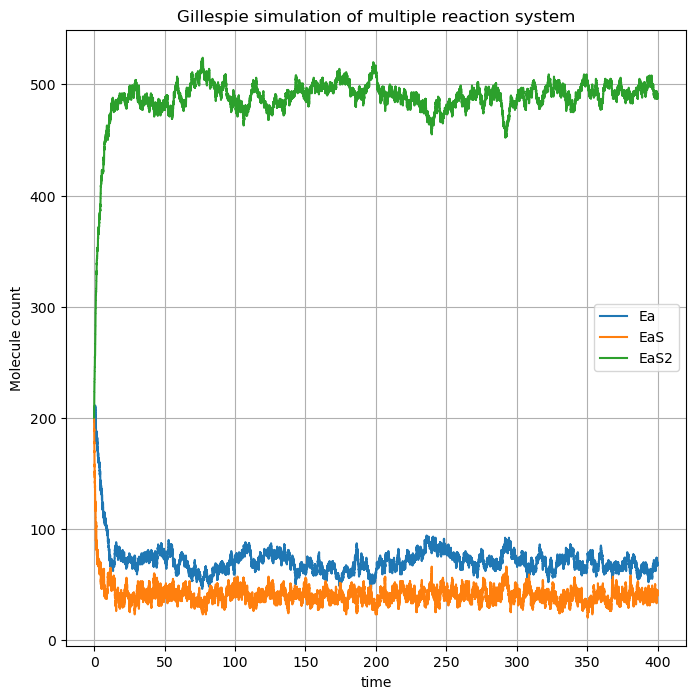

Final Ea: 68
Final EaS: 41
Final EaS2: 491
No. times each reaction fires: [6375, 280, 8627, 2540, 8610, 8607]
Averaged currents of each reaction: [15.708762886597938, 15.688144329896907, 0.007731958762886598]
Averaged forces along each reaction: [2.77635793379844, -3.06131721832597, 1.10968548524810]
Averaged resistances: [0.176739438607677, -0.195135712290205, 143.519322758754]
Total Loop time: 40.9234619140625
Prop function time: 8.584603309631348
Summing prop vector time: 1.6286473274230957
Calculating tau: 8.385948896408081
Reaction selection time: 2.151860237121582
Calculating iteration current and prop ratio time: 4.327357053756714
Updates time: 6.622966051101685
Plotting and averaging time: -1.8212649822235107
Total iterations: 39615


In [566]:
SM = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])

species_names = ["Ea", "EaS","EaS2","S","Na"]

module_for_simulating = ModuleProperties(SM, 3, species_names)

# RunSSA input requiremetns 

initial_counts = [200, 200, 200, 50, 50]

rates = [0.005, 0.02, 0.6, 0.002, 0.012, 0.05]

simulation_length = 400.0
# 


SIM = RunSSA(module_for_simulating, initial_counts, rates, simulation_length)
SIM.run_SSA_and_plot_counts()




In [387]:
SIM.propensity_vector

array([46.7500000000000, 1.72000000000000, 51.6000000000000,
       18.7000000000000, 51.6000000000000, 61.3500000000000], dtype=object)

In [499]:
# Script to repeat SSA for same intial coniditions to see variablility in results:
# - could have differences due to seeding of random numbers? Mentioned in Gillespie (i think)

iteration = 0

currents = []
forces = []
resistances = []

while iteration < 100:

    SIM = RunSSA(module_for_simulating, initial_counts, rates, simulation_length)

    SIM.run_SSA_and_plot_counts() # run the simulation

    currents.append(SIM.average_reaction_currents) # store the averaged currents for this run

    forces.append(SIM.averaged_forces) # store averaged forces for this run

    resistances.append(SIM.average_resistances) # store average resistances for this run

    print(r'Run: {}'.format(iteration))

    iteration += 1

    




Init functions time taken: 0.0024869441986083984
Final Ea: 86
Final EaS: 36
Final EaS2: 478
No. times each reaction fires: [6265, 293, 8639, 2649, 8590, 8600]
Averaged currents of each reaction: [15.391752577319588, 15.438144329896907, -0.02577319587628866]
Averaged forces along each reaction: [2.79613650057872, -3.06108353660273, 1.08961028232785]
Averaged resistances: [0.181664595148115, -0.198280536260744, -42.2768789543207]
Total Loop time: 35.23010516166687
Prop function time: 7.21326470375061
Summing prop vector time: 1.3080394268035889
Calculating tau: 6.690119743347168
Reaction selection time: 1.887662410736084
Calculating iteration current and prop ratio time: 4.235419034957886
Updates time: 5.50022292137146
Plotting and averaging time: -0.45722293853759766
Total iterations: 39786
Run: 0
Init functions time taken: 0.0007390975952148438
Final Ea: 66
Final EaS: 37
Final EaS2: 497
No. times each reaction fires: [6544, 286, 8890, 2643, 8744, 8724]
Averaged currents of each reactio

In [554]:
print(forces)

[[2.79613650057872, -3.06108353660273, 1.08961028232785], [2.79348599145804, -3.06098374909019, 1.09213412094080], [2.80139827316575, -3.06120539749035, 1.08450320024386], [2.80175258557709, -3.06110006755758, 1.08401518176326], [2.78838970609478, -3.06104723884859, 1.09731100035570], [2.80737289237741, -3.06095708955242, 1.07821337834027], [2.80860757965332, -3.06098434121433, 1.07701328438925], [2.79326834128919, -3.06099038672825, 1.09236019694332], [2.77710916345954, -3.06109292272018, 1.10864953420705], [2.76829969941873, -3.06140741229947, 1.11785821207404], [2.76601986500368, -3.06104855611154, 1.11968251358349], [2.77630985411056, -3.06122468517389, 1.10961610313077], [2.79537746109627, -3.06103179012183, 1.09030363470342], [2.80883269068258, -3.06109611775154, 1.07693006276447], [2.76616570157515, -3.06082243554859, 1.11924963902711], [2.80866935286836, -3.06118151659086, 1.07720180607011], [2.81002962953668, -3.06119407299111, 1.07585746852646], [2.80387212336897, -3.06106670

In [511]:
all_currents_r1 = []
all_currents_r2 = []
all_currents_r3 = []

for current in currents:

    all_currents_r1.append(current[0])
    all_currents_r2.append(current[1])
    all_currents_r3.append(current[2])

J1 = np.array(all_currents_r1)  # length 50
J2 = np.array(all_currents_r2)
J3 = np.array(all_currents_r3)

data = np.column_stack((J1, J2, J3))

np.cov(data, rowvar=False)


array([[0.06314565, 0.06179848, 0.00090616],
       [0.06179848, 0.0612532 , 0.00012853],
       [0.00090616, 0.00012853, 0.00118826]])

In [563]:
all_forces_r1 = []
all_forces_r2 = []
all_forces_r3 = []

for force in forces:

    all_forces_r1.append(force[0])
    all_forces_r2.append(force[1])
    all_forces_r3.append(force[2])

F1 = np.array(all_forces_r1, dtype=float)  # length 50
F2 = np.array(all_forces_r2)
F3 = np.array(all_forces_r3)

dataF = np.column_stack((F1, F2, F3))

#np.cov(dataF, rowvar=False)

print(F1)

[2.7961365  2.79348599 2.80139827 2.80175259 2.78838971 2.80737289
 2.80860758 2.79326834 2.77710916 2.7682997  2.76601987 2.77630985
 2.79537746 2.80883269 2.7661657  2.80866935 2.81002963 2.80387212
 2.79521558 2.81632445 2.79184782 2.80128585 2.78731949 2.80724614
 2.79859491 2.73376457 2.79537373 2.80654268 2.78598976 2.80894406
 2.79416014 2.81212577 2.77655408 2.78599409 2.80146462 2.7622277
 2.79863062 2.78160066 2.79438578 2.78193787 2.79419533 2.82370026
 2.78076412 2.78917382 2.80179524 2.77328746 2.79034291 2.78527416
 2.79707459 2.78443328 2.78912806 2.79925147 2.81291792 2.82179883
 2.79020513 2.79365209 2.8091656  2.79300128 2.80245705 2.80008533
 2.79700677 2.80735226 2.8001631  2.79924572 2.80156938 2.7920404
 2.77484021 2.78958628 2.79011642 2.80877521 2.83282453 2.79354797
 2.80732188 2.78774016 2.78966497 2.83017371 2.78173143 2.78947151
 2.78477792 2.78351525 2.80109248 2.77944417 2.79765528 2.79681665
 2.79744939 2.79800084 2.79061163 2.80359703 2.77573797 2.792714

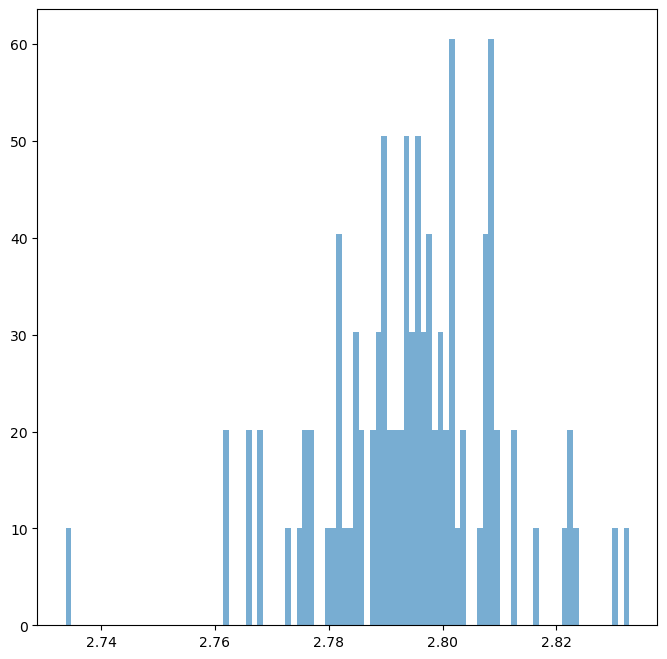

In [564]:
# x = np.linspace(0,100,100)
# plt.scatter(x,J1)
# plt.scatter(x,J2)
# #plt.scatter(x,J3)
mu = np.mean(F1)
sigma = np.std(F1)

plt.hist(F1, bins=100, density=True, alpha=0.6)

# x = np.linspace(min(F1), max(F1), 500)
# gaussian = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2*sigma**2))

# plt.plot(x, gaussian, 'r', linewidth=2)
plt.show()

# Now test with Module 2

In [179]:
stoich_matrix_2 = Matrix([[-1, 0, 1, 0, 0], # first row of internal
                           [1, -1, 0, -1, 0], 
                           [0, 1, -1, 0, 1], 
                           [0, 0, 0, 1, -1],
                             [0, 0, 0, -1, 0], # first row external 
                             [0, 0, 0, 0, 1],
                             [-1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0]])

species_names2 = ["Eb", "EbF", "EbW", "Eb*", "Na", "Nb", "F", "W"]

module2_for_simulation = ModuleProperties(stoich_matrix_2, 4, species_names2)

initial_counts2 = [1000, 1000, 1000, 1000, 50, 50, 50, 50]

rates2 = [0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01]

simulation_length2 = 50.0

SIM_2 = RunSSA(module2_for_simulation, initial_counts2, rates2, simulation_length2)

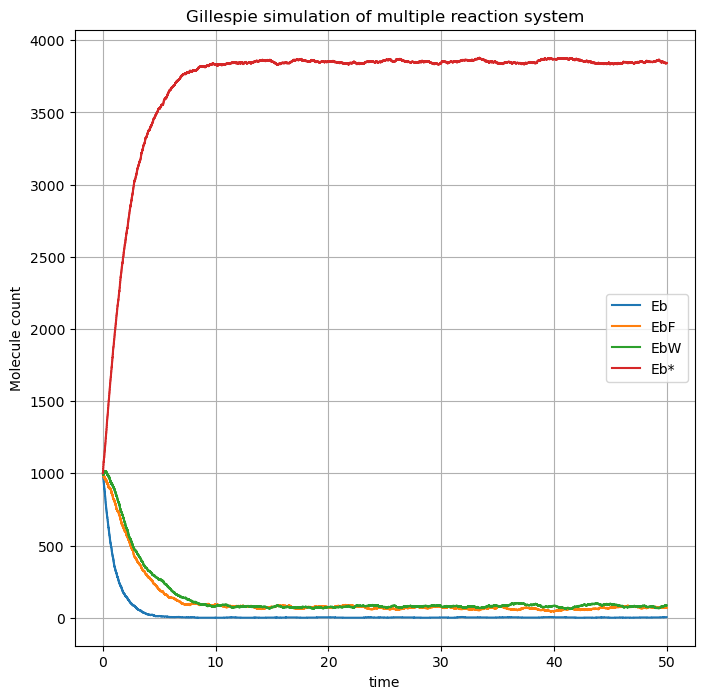

Final Eb: 4
Final EbF: 69
Final EbW: 84
Final Eb*: 3843
No. times each reaction fires: [28, 23, 24, 31, 33, 25, 1421, 1397, 1558, 1539]
The averaged current for each reaction: [0.13157894736842105, -0.18421052631578946, 0.21052631578947367, 0.631578947368421, 0.5]


In [180]:
SIM_2.run_SSA_and_plot_counts()